In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

pd.show_versions()


INSTALLED VERSIONS
------------------
commit           : db08276bc116c438d3fdee492026f8223584c477
python           : 3.8.5.final.0
python-bits      : 64
OS               : Windows
OS-release       : 10
Version          : 10.0.19041
machine          : AMD64
processor        : Intel64 Family 6 Model 94 Stepping 3, GenuineIntel
byteorder        : little
LC_ALL           : None
LANG             : None
LOCALE           : Spanish_Mexico.1252

pandas           : 1.1.3
numpy            : 1.19.2
pytz             : 2020.1
dateutil         : 2.8.1
pip              : 20.2.4
setuptools       : 50.3.1.post20201107
Cython           : 0.29.21
pytest           : 6.1.1
hypothesis       : None
sphinx           : 3.2.1
blosc            : None
feather          : None
xlsxwriter       : 1.3.7
lxml.etree       : 4.6.1
html5lib         : 1.1
pymysql          : None
psycopg2         : None
jinja2           : 2.11.2
IPython          : 7.19.0
pandas_datareader: None
bs4              : 4.9.3
bottleneck       : 1

In [2]:
df = pd.read_csv('sentiment-bitcoin.csv')
df = df.rename(columns = {'Unnamed: 0': 'timestamp'})
df.head()

,timestamp,Polarity,Sensitivity,Tweet_vol,Open,High,Low,Volume_BTC,Volume_Dollar,Close_Price
0,2018-07-11 20:00:00,0.102657,0.216148,4354.0,6342.97,6354.19,6291.00,986.73,6231532.37,6350.00
1,2018-07-11 21:00:00,0.098004,0.218612,4432.0,6352.99,6370.00,6345.76,126.46,804221.55,6356.48
2,2018-07-11 22:00:00,0.096688,0.231342,3980.0,6350.85,6378.47,6345.00,259.10,1646353.87,6361.93
3,2018-07-11 23:00:00,0.103997,0.217739,3830.0,6362.36,6381.25,6356.74,81.54,519278.69,6368.78
4,2018-07-12 00:00:00,0.094383,0.195256,3998.0,6369.49,6381.25,6361.83,124.55,793560.22,6380.00


## Simple metrics study

In [3]:
df['Polarity'].describe()

count    294.000000
mean       0.099534
std        0.012114
min        0.051695
25%        0.091489
50%        0.099198
75%        0.106649
max        0.135088
Name: Polarity, dtype: float64

In [4]:
df['Sensitivity'].describe()

count    294.000000
mean       0.214141
std        0.014940
min        0.174330
25%        0.203450
50%        0.214756
75%        0.223910
max        0.271796
Name: Sensitivity, dtype: float64

In [5]:
df['Tweet_vol'].describe()

count      294.000000
mean      4691.119048
std       1048.922706
min       2998.000000
25%       3878.750000
50%       4452.000000
75%       5429.750000
max      10452.000000
Name: Tweet_vol, dtype: float64

In [6]:
df['Close_Price'].describe()

count     294.000000
mean     6920.150000
std       565.424866
min      6149.110000
25%      6283.497500
50%      7281.975000
75%      7424.560000
max      7750.090000
Name: Close_Price, dtype: float64

## Detecting outliers / sudden spikes in our close prices

In [7]:
def detect(signal, treshold = 2.0):
    detected = []
    for i in range(len(signal)):
        if np.abs(signal[i]) > treshold:
            detected.append(i)
    return detected

In [8]:
signal = np.copy(df['Close_Price'].values)
std_signal = (signal - np.mean(signal)) / np.std(signal)
s = pd.Series(std_signal)
s.describe(percentiles = [0.25, 0.5, 0.75, 0.95])

count    2.940000e+02
mean     2.409259e-15
std      1.001705e+00
min     -1.365972e+00
25%     -1.127892e+00
50%      6.410081e-01
75%      8.936113e-01
95%      1.375160e+00
max      1.470319e+00
dtype: float64

In [9]:
outliers = detect(std_signal, 1.3)

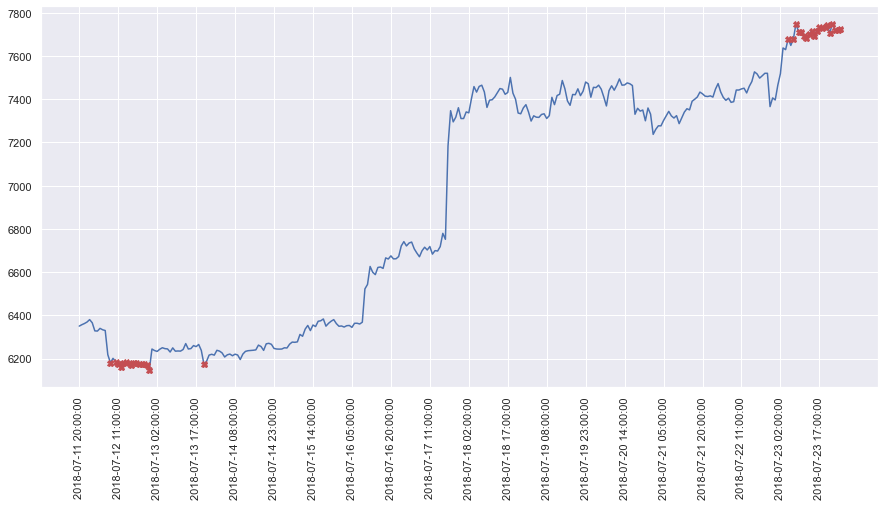

In [10]:
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), signal)
plt.plot(
    np.arange(len(signal)),
    signal,
    'X',
    label = 'outliers',
    markevery = outliers,
    c = 'r',
)
plt.xticks(
    np.arange(len(signal))[::15], df['timestamp'][::15], rotation = 'vertical'
)
plt.show()

In [11]:
from sklearn.preprocessing import MinMaxScaler

minmax = MinMaxScaler().fit(df[['Polarity', 'Sensitivity', 'Close_Price']])
scaled = minmax.transform(df[['Polarity', 'Sensitivity', 'Close_Price']])

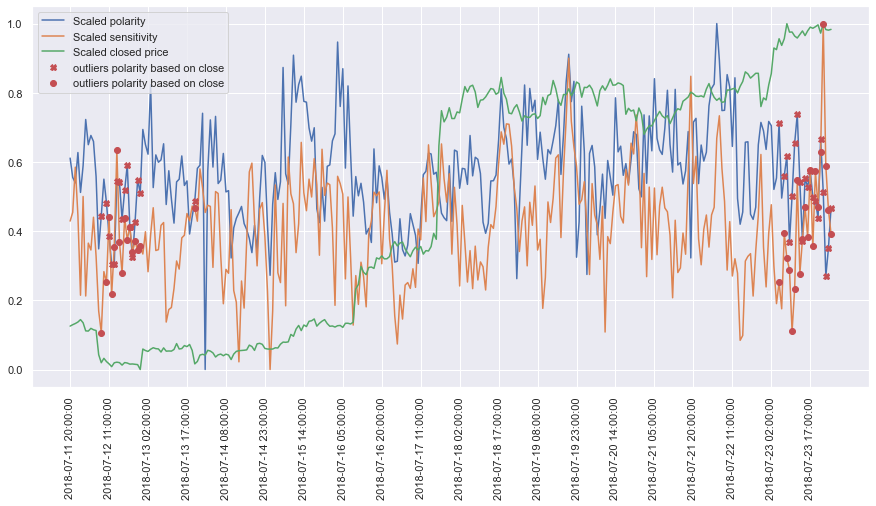

In [12]:
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), scaled[:, 0], label = 'Scaled polarity')
plt.plot(np.arange(len(signal)), scaled[:, 1], label = 'Scaled sensitivity')
plt.plot(np.arange(len(signal)), scaled[:, 2], label = 'Scaled closed price')
plt.plot(
    np.arange(len(signal)),
    scaled[:, 0],
    'X',
    label = 'outliers polarity based on close',
    markevery = outliers,
    c = 'r',
)
plt.plot(
    np.arange(len(signal)),
    scaled[:, 1],
    'o',
    label = 'outliers polarity based on close',
    markevery = outliers,
    c = 'r',
)
plt.xticks(
    np.arange(len(signal))[::15], df['timestamp'][::15], rotation = 'vertical'
)
plt.legend()
plt.show()

Doesnt show much from trending, how about covariance correlation?

## Pearson correlation

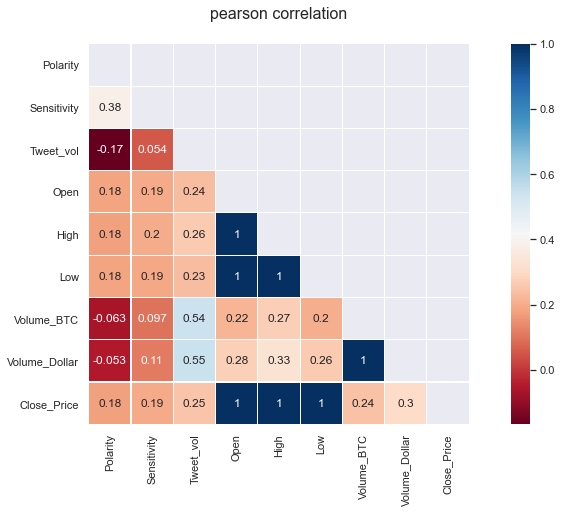

In [13]:
colormap = plt.cm.RdBu
plt.figure(figsize = (15, 7))
plt.title('pearson correlation', y = 1.05, size = 16)

mask = np.zeros_like(df.corr())
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    df.corr(),
    mask = mask,
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()

In [14]:
def df_shift(df, lag = 0, start = 1, skip = 1, rejected_columns = []):
    df = df.copy()
    if not lag:
        return df
    cols = {}
    for i in range(start, lag + 1, skip):
        for x in list(df.columns):
            if x not in rejected_columns:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
    for k, v in cols.items():
        columns = v
        dfn = pd.DataFrame(data = None, columns = columns, index = df.index)
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods = i)
            i += 1
        df = pd.concat([df, dfn], axis = 1)
        df.reset_index
    return df

In [15]:
df_new = df_shift(df, lag = 42, start = 7, skip = 7)
df_new.shape

(294, 70)

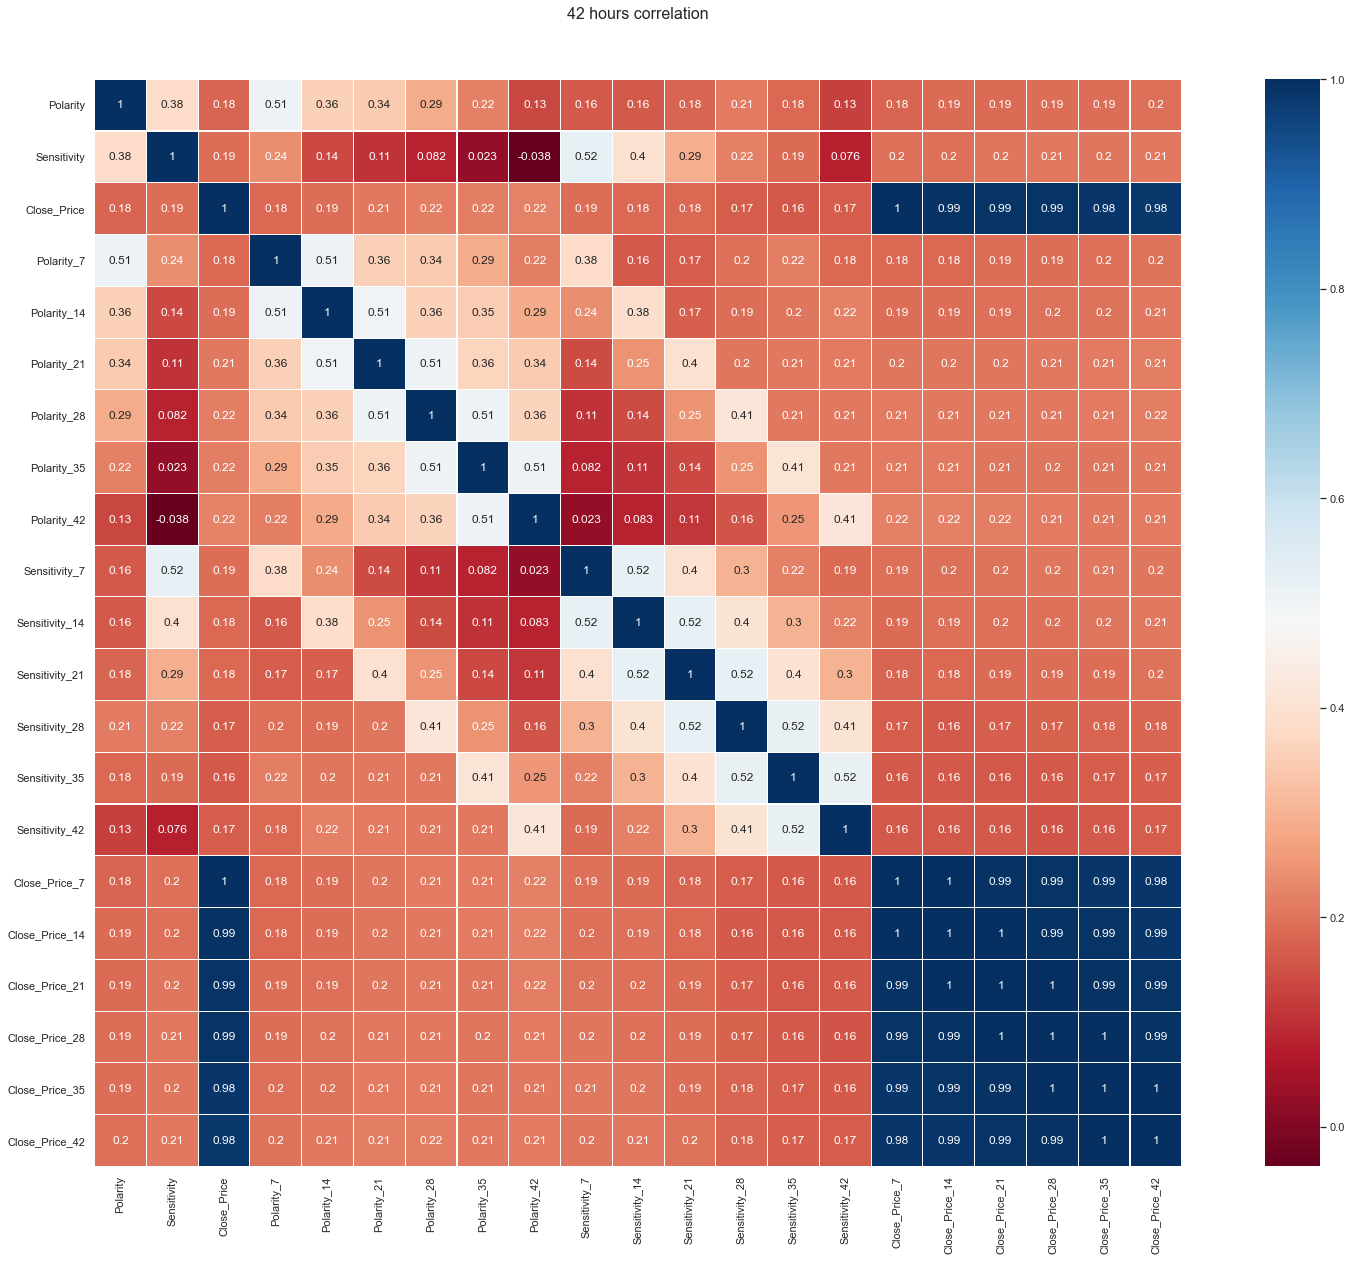

In [16]:
colormap = plt.cm.RdBu
plt.figure(figsize = (30, 20))
ax = plt.subplot(111)
plt.title('42 hours correlation', y = 1.05, size = 16)
selected_column = [
    col
    for col in list(df_new)
    if any([k in col for k in ['Polarity', 'Sensitivity', 'Close']])
]

sns.heatmap(
    df_new[selected_column].corr(),
    ax = ax,
    linewidths = 0.1,
    vmax = 1.0,
    square = True,
    cmap = colormap,
    linecolor = 'white',
    annot = True,
)
plt.show()

## How about we check trends from moving average? i chose 7, 14, 30 hours

I think i had too much playing daily trending data

In [17]:
def moving_average(signal, period):
    buffer = [np.nan] * period
    for i in range(period, len(signal)):
        buffer.append(signal[i - period : i].mean())
    return buffer

In [18]:
signal = np.copy(df['Close_Price'].values)
ma_7 = moving_average(signal, 7)
ma_14 = moving_average(signal, 14)
ma_30 = moving_average(signal, 30)

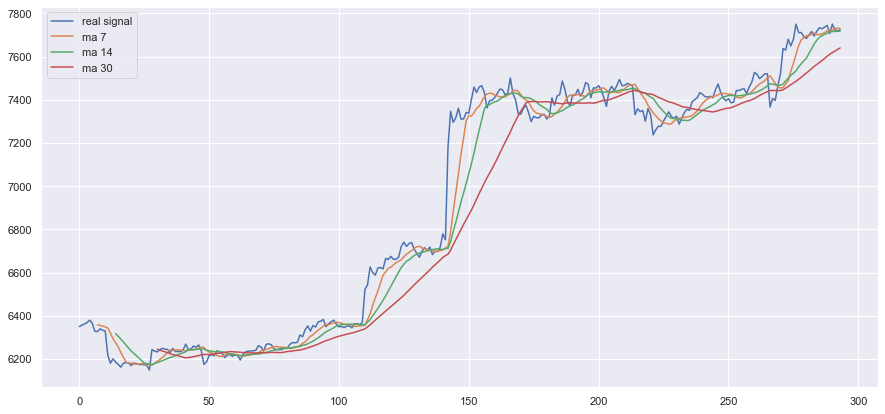

In [19]:
plt.figure(figsize = (15, 7))
plt.plot(np.arange(len(signal)), signal, label = 'real signal')
plt.plot(np.arange(len(signal)), ma_7, label = 'ma 7')
plt.plot(np.arange(len(signal)), ma_14, label = 'ma 14')
plt.plot(np.arange(len(signal)), ma_30, label = 'ma 30')
plt.legend()
plt.show()

Trends gonna increase anyway!

## Now deep learning LSTM

In [20]:
num_layers = 1
learning_rate = 0.005
size_layer = 128
timestamp = 5
epoch = 500
dropout_rate = 0.6

In [21]:
dates = pd.to_datetime(df.iloc[:, 0]).tolist()

In [22]:
class Model:
    def __init__(
        self, learning_rate, num_layers, size, size_layer, forget_bias = 0.8
    ):
        def lstm_cell(size_layer):
            return tf.nn.rnn_cell.LSTMCell(size_layer, state_is_tuple = False)

        rnn_cells = tf.nn.rnn_cell.MultiRNNCell(
            [lstm_cell(size_layer) for _ in range(num_layers)],
            state_is_tuple = False,
        )
        self.X = tf.placeholder(tf.float32, (None, None, size))
        self.Y = tf.placeholder(tf.float32, (None, size))
        drop = tf.contrib.rnn.DropoutWrapper(
            rnn_cells, output_keep_prob = forget_bias
        )
        self.hidden_layer = tf.placeholder(
            tf.float32, (None, num_layers * 2 * size_layer)
        )
        self.outputs, self.last_state = tf.nn.dynamic_rnn(
            drop, self.X, initial_state = self.hidden_layer, dtype = tf.float32
        )
        self.logits = tf.layers.dense(
            self.outputs[-1],
            size,
            kernel_initializer = tf.glorot_uniform_initializer(),
        )
        self.cost = tf.reduce_mean(tf.square(self.Y - self.logits))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(
            self.cost
        )

In [23]:
minmax = MinMaxScaler().fit(
    df[['Polarity', 'Sensitivity', 'Tweet_vol', 'Close_Price']].astype(
        'float32'
    )
)
df_scaled = minmax.transform(
    df[['Polarity', 'Sensitivity', 'Tweet_vol', 'Close_Price']].astype(
        'float32'
    )
)
df_scaled = pd.DataFrame(df_scaled)
df_scaled.head()

,0,1,2,3
0,0.611105,0.429055,0.181916,0.125479
1,0.555312,0.454335,0.192380,0.129527
2,0.539534,0.584943,0.131741,0.132931
3,0.627175,0.445375,0.111618,0.137210
4,0.511893,0.214693,0.134156,0.144218


In [24]:
tf.reset_default_graph()
modelnn = Model(
    learning_rate, num_layers, df_scaled.shape[1], size_layer, dropout_rate
)
sess = tf.InteractiveSession()
sess.run(tf.global_variables_initializer())

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

We need to scale our data between 0 - 1 or any scaled you wanted, but must not less than -1 and more than 1, because LSTM is using tanh function, squashing high values can caused gradient vanishing later

In [ ]:
for i in range(epoch):
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    total_loss = 0
    for k in range(0, (df_scaled.shape[0] // timestamp) * timestamp, timestamp):
        batch_x = np.expand_dims(
            df_scaled.iloc[k : k + timestamp].values, axis = 0
        )
        batch_y = df_scaled.iloc[k + 1 : k + timestamp + 1].values
        last_state, _, loss = sess.run(
            [modelnn.last_state, modelnn.optimizer, modelnn.cost],
            feed_dict = {
                modelnn.X: batch_x,
                modelnn.Y: batch_y,
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        total_loss += loss
    total_loss /= df.shape[0] // timestamp
    if (i + 1) % 100 == 0:
        print('epoch:', i + 1, 'avg loss:', total_loss)

In [ ]:
def predict_future(future_count, df, dates, indices = {}):
    date_ori = dates[:]
    cp_df = df.copy()
    output_predict = np.zeros((cp_df.shape[0] + future_count, cp_df.shape[1]))
    output_predict[0] = cp_df.iloc[0]
    upper_b = (cp_df.shape[0] // timestamp) * timestamp
    init_value = np.zeros((1, num_layers * 2 * size_layer))
    for k in range(0, (df.shape[0] // timestamp) * timestamp, timestamp):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(
                    cp_df.iloc[k : k + timestamp], axis = 0
                ),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[k + 1 : k + timestamp + 1] = out_logits
    out_logits, last_state = sess.run(
        [modelnn.logits, modelnn.last_state],
        feed_dict = {
            modelnn.X: np.expand_dims(cp_df.iloc[upper_b:], axis = 0),
            modelnn.hidden_layer: init_value,
        },
    )
    init_value = last_state
    output_predict[upper_b + 1 : cp_df.shape[0] + 1] = out_logits
    cp_df.loc[cp_df.shape[0]] = out_logits[-1]
    date_ori.append(date_ori[-1] + timedelta(hours = 1))
    if indices:
        for key, item in indices.items():
            cp_df.iloc[-1, key] = item
    for i in range(future_count - 1):
        out_logits, last_state = sess.run(
            [modelnn.logits, modelnn.last_state],
            feed_dict = {
                modelnn.X: np.expand_dims(cp_df.iloc[-timestamp:], axis = 0),
                modelnn.hidden_layer: init_value,
            },
        )
        init_value = last_state
        output_predict[cp_df.shape[0]] = out_logits[-1]
        cp_df.loc[cp_df.shape[0]] = out_logits[-1]
        date_ori.append(date_ori[-1] + timedelta(hours = 1))
        if indices:
            for key, item in indices.items():
                cp_df.iloc[-1, key] = item
    return {'date_ori': date_ori, 'df': cp_df.values}

Define some smoothing, using previous value as an anchor

In [ ]:
def anchor(signal, weight):
    buffer = []
    last = signal[0]
    for i in signal:
        smoothed_val = last * weight + (1 - weight) * i
        buffer.append(smoothed_val)
        last = smoothed_val
    return buffer

In [ ]:
predict_30 = predict_future(30, df_scaled, dates)
predict_30['df'] = minmax.inverse_transform(predict_30['df'])

In [ ]:
plt.figure(figsize = (15, 7))
plt.plot(
    np.arange(len(predict_30['date_ori'])),
    anchor(predict_30['df'][:, -1], 0.5),
    label = 'predict signal',
)
plt.plot(np.arange(len(signal)), signal, label = 'real signal')
plt.legend()
plt.show()

#### What happen if polarity is double from the max? Polarity is first index

In [ ]:
scaled_polarity = (minmax.data_max_[0] * 2 - minmax.data_min_[0]) / (
    minmax.data_max_[0] - minmax.data_min_[0]
)
scaled_polarity

In [ ]:
plt.figure(figsize = (15, 7))

for retry in range(3):
    plt.subplot(3, 1, retry + 1)
    predict_30 = predict_future(
        30, df_scaled, dates, indices = {0: scaled_polarity}
    )
    predict_30['df'] = minmax.inverse_transform(predict_30['df'])
    plt.plot(
        np.arange(len(predict_30['date_ori'])),
        anchor(predict_30['df'][:, -1], 0.5),
        label = 'predict signal',
    )
    plt.plot(np.arange(len(signal)), signal, label = 'real signal')
    plt.legend()
plt.show()

I retried for 3 times just to study how fitted our model is, if every retry has big trend changes, so we need to retrain again.

#### What happen if polarity is quadriple from the max? Polarity is first index

In [ ]:
scaled_polarity = (minmax.data_max_[0] * 4 - minmax.data_min_[0]) / (
    minmax.data_max_[0] - minmax.data_min_[0]
)
scaled_polarity

In [ ]:
plt.figure(figsize = (15, 7))

for retry in range(3):
    plt.subplot(3, 1, retry + 1)
    predict_30 = predict_future(
        30, df_scaled, dates, indices = {0: scaled_polarity}
    )
    predict_30['df'] = minmax.inverse_transform(predict_30['df'])
    plt.plot(
        np.arange(len(predict_30['date_ori'])),
        anchor(predict_30['df'][:, -1], 0.5),
        label = 'predict signal',
    )
    plt.plot(np.arange(len(signal)), signal, label = 'real signal')
    plt.legend()
plt.show()

#### What happen if polarity is quadriple from the min? polarity is first index

In [ ]:
scaled_polarity = (minmax.data_min_[0] / 4 - minmax.data_min_[0]) / (
    minmax.data_max_[0] - minmax.data_min_[0]
)
scaled_polarity

In [ ]:
plt.figure(figsize = (15, 7))

for retry in range(3):
    plt.subplot(3, 1, retry + 1)
    predict_30 = predict_future(
        30, df_scaled, dates, indices = {0: scaled_polarity}
    )
    predict_30['df'] = minmax.inverse_transform(predict_30['df'])
    plt.plot(
        np.arange(len(predict_30['date_ori'])),
        anchor(predict_30['df'][:, -1], 0.5),
        label = 'predict signal',
    )
    plt.plot(np.arange(len(signal)), signal, label = 'real signal')
    plt.legend()
plt.show()

The second graph is skewed, but we got 2 graphs represented positive trends

As you can see, the model learnt that, polarity gives negative correlation to the model. If polarity is increase, the trend is decreasing, vice versa

#### What happen if sentiment volume is double from the max? Volume is third index

In [ ]:
scaled_volume = (minmax.data_max_[2] * 2 - minmax.data_min_[2]) / (
    minmax.data_max_[2] - minmax.data_min_[2]
)
scaled_volume


In [ ]:
plt.figure(figsize = (15, 7))

for retry in range(3):
    plt.subplot(3, 1, retry + 1)
    predict_30 = predict_future(
        30, df_scaled, dates, indices = {2: scaled_volume}
    )
    predict_30['df'] = minmax.inverse_transform(predict_30['df'])
    plt.plot(
        np.arange(len(predict_30['date_ori'])),
        anchor(predict_30['df'][:, -1], 0.5),
        label = 'predict signal',
    )
    plt.plot(np.arange(len(signal)), signal, label = 'real signal')
    plt.legend()
plt.show()

#### What happen if sentiment volume is double from the min? Volume is third index

In [ ]:
scaled_volume = (minmax.data_min_[2] / 2 - minmax.data_min_[2]) / (
    minmax.data_max_[2] - minmax.data_min_[2]
)
scaled_volume

In [ ]:
plt.figure(figsize = (15, 7))

for retry in range(3):
    plt.subplot(3, 1, retry + 1)
    predict_30 = predict_future(
        30, df_scaled, dates, indices = {2: scaled_volume}
    )
    predict_30['df'] = minmax.inverse_transform(predict_30['df'])
    plt.plot(
        np.arange(len(predict_30['date_ori'])),
        anchor(predict_30['df'][:, -1], 0.5),
        label = 'predict signal',
    )
    plt.plot(np.arange(len(signal)), signal, label = 'real signal')
    plt.legend()
plt.show()

As you can see, volume does not brings any impact the learning so much